In [1]:
import pandas as pd
import numpy as np
import torch.nn.functional as F
from copy import deepcopy
import warnings
warnings.simplefilter('ignore')
import torchviz
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from torch.utils.tensorboard import SummaryWriter
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import joblib
import os
from sklearn.preprocessing import StandardScaler
import time
def get_col(df,name):
    return df.columns[df.columns.str.contains(name)].tolist()
os.listdir('../data')

['dataset.pkl',
 'PA_201605-2020001更新R10(20200602).csv',
 'tag_cleaned.csv',
 'tag盤點表20200423.xlsx',
 'tag盤點表20200602R1.xlsx',
 'train_cleaned.csv',
 '反應槽(20200201-20200212)開車資料.csv']

# load data

In [2]:
tag = pd.read_csv('../data/tag_cleaned.csv',index_col=0)
tag = tag.loc[tag.category=='可控制因子']

In [3]:
data = joblib.load('../data/dataset.pkl')
data.keys()

dict_keys(['state', 'action', 'output', 'stream', 'idx', 'mm_state', 'mm_action', 'mm_output', 'mm_stream', 'state_col', 'action_col', 'output_col', 'stream_col'])

# tensor data

In [4]:
state = torch.FloatTensor(data['state']).cuda()
action = torch.FloatTensor(data['action']).cuda()
output = torch.FloatTensor(data['output']).cuda()
stream = torch.FloatTensor(data['stream']).cuda()

# split data

In [5]:
test_df = pd.read_csv('../data/反應槽(20200201-20200212)開車資料.csv',
                 index_col=0,
                 parse_dates=True,
                 encoding='latin-1')
test_df = test_df.dropna(axis=0)
print(test_df.shape)

(1585, 97)


In [6]:
sp1 = len(state)-10000
sp2 = len(state)-test_df.shape[0]
print(sp1,sp2)

116443 124858


# data_iter

In [7]:
train = torch.utils.data.TensorDataset(state[:sp1],action[:sp1],output[:sp1],stream[:sp1])
valid = torch.utils.data.TensorDataset(state[sp1:sp2],action[sp1:sp2],output[sp1:sp2],stream[sp1:sp2])
test = torch.utils.data.TensorDataset(state[sp2:],action[sp2:],output[sp2:],stream[sp2:])

train_iter = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)
valid_iter = torch.utils.data.DataLoader(valid, batch_size=128, shuffle=True)

In [8]:
print(action.shape)
time_step = action.shape[1]
num_sensor = action.shape[2]

torch.Size([126443, 36, 11])


# Construct the neural network

In [9]:
class Critic(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.time_step = time_step
        self.num_sensor = num_sensor
        self.h_size = 64
        
        self.output_layer = nn.Sequential(nn.Linear(self.h_size,self.h_size),
                                          nn.ReLU(),
                                          nn.Linear(self.h_size,1),
                                         )
        
        self.stream_layer = nn.Sequential(nn.Linear(self.h_size,self.h_size),
                                          nn.ReLU(),
                                          nn.Linear(self.h_size,1),
                                         )
        
        self.conv_layer = nn.Sequential(nn.Conv1d(self.num_sensor,self.h_size-1,kernel_size = 36),
                                        nn.ReLU(),
                                       )
        
        self.fc_layer = nn.Sequential(nn.Linear(461,self.h_size),
                                          nn.ReLU(),
                                          nn.Linear(self.h_size,self.h_size),
                                         )
        
    def forward(self,state,action):
        batch_size = state.shape[0]
        
        # action have two path,path_1 and path_2
        action_1 = self.conv_layer(action.permute(0,2,1)).reshape(batch_size,-1)
        action_2 = action.reshape(batch_size,-1)
        
        # combine two path action_1,action_2
        action = torch.cat((action_1,action_2),dim=-1)
        
        # combine state action
        combine = torch.cat((state,action),dim=-1)
        
        # fc forward
        combine = self.fc_layer(combine)
        
        # get output and stream
        output = self.output_layer(combine)
        stream = self.stream_layer(combine)
        
        return F.sigmoid(output),F.sigmoid(stream)

In [10]:
def init_weights(m):
    if hasattr(m,'weight'):
        try:
            torch.nn.init.xavier_uniform(m.weight)
        except:
            pass
    
    if hasattr(m,'bias'):
        try:
            m.bias.data.fill_(0.1)
        except:
            pass

In [11]:
net = Critic().cuda()
net.apply(init_weights)

Critic(
  (output_layer): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (stream_layer): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (conv_layer): Sequential(
    (0): Conv1d(11, 63, kernel_size=(36,), stride=(1,))
    (1): ReLU()
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=461, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
  )
)

# forward test

In [12]:
a,b = net(state,action)
print(a.shape)
print(b.shape)

torch.Size([126443, 1])
torch.Size([126443, 1])


# tensorboard

In [13]:
with SummaryWriter(comment='Net')as w:
    w.add_graph(net, (test.tensors[0:2]))

# loss and opt

In [14]:
optimizer = torch.optim.Adam(net.parameters(),lr=1e-3)

In [15]:
def loss_function(output,stream,target_output,target_stream):
    loss1 = ((output-target_output)**2).sum()
    loss2 = ((stream-target_stream)**2).sum()
    return 0.5*loss1 + 0.0*loss2

# train and eval

In [16]:
def train(net,train_iter,valid_iter,loss_function,optimizer,num_epochs=100):
    train_history = []
    valid_history = []
    best_loss = np.inf
    best_net = None
    for epoch in range(num_epochs): 
        
        # train model
        net.train()
        train_loss,i = 0,0
        for state,action,output,stream in train_iter:
            output_pred,stream_pred = net(state,action)
            loss = loss_function(output_pred,stream_pred,output,stream)
            train_loss += loss.item()
            i += 1
            
            # update model
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # eval model (afater update model)
        with torch.no_grad():
            net.eval()
            val_loss,j = 0,0
            for state,action,output,stream in valid_iter:
                output_pred,stream_pred = net(state,action)
                loss = loss_function(output_pred,stream_pred,output,stream)
                val_loss += loss.item()
                j += 1
        
        # caculate avg_loss
        train_avg_loss = train_loss/i
        val_avg_loss = val_loss/j
        
        # save the best_model
        if val_avg_loss <= best_loss:
            best_loss = val_avg_loss
            best_net = deepcopy(net) #backup the model(deepcopy)
            print('model recorded!')
        
        # record history and print loss of the epoch
        train_history.append(train_avg_loss)
        valid_history.append(val_avg_loss)
        print("epochs {} train_avg_loss {:.4f} valid_avg_loss {:.4f}".format(
            epoch,train_avg_loss,val_avg_loss))
        
    # plot result
    print('best val_avg_loss is ',best_loss)
    
    fig = plt.figure(figsize=(20,5))
    plt.plot(np.array(train_history),label='train')
    plt.plot(np.array(valid_history),label='valid')
    plt.legend()
    plt.title('loss')
    plt.show()
    
    return best_net.eval()

model recorded!
epochs 0 train_avg_loss 0.1054 valid_avg_loss 0.0962
model recorded!
epochs 1 train_avg_loss 0.0585 valid_avg_loss 0.0626
epochs 2 train_avg_loss 0.0564 valid_avg_loss 0.1037
epochs 3 train_avg_loss 0.0557 valid_avg_loss 0.0873
epochs 4 train_avg_loss 0.0554 valid_avg_loss 0.0761
epochs 5 train_avg_loss 0.0544 valid_avg_loss 0.1661
epochs 6 train_avg_loss 0.0531 valid_avg_loss 0.1584
epochs 7 train_avg_loss 0.0531 valid_avg_loss 0.0876
epochs 8 train_avg_loss 0.0512 valid_avg_loss 0.0631
epochs 9 train_avg_loss 0.0511 valid_avg_loss 0.0886
best val_avg_loss is  0.06257023080957658


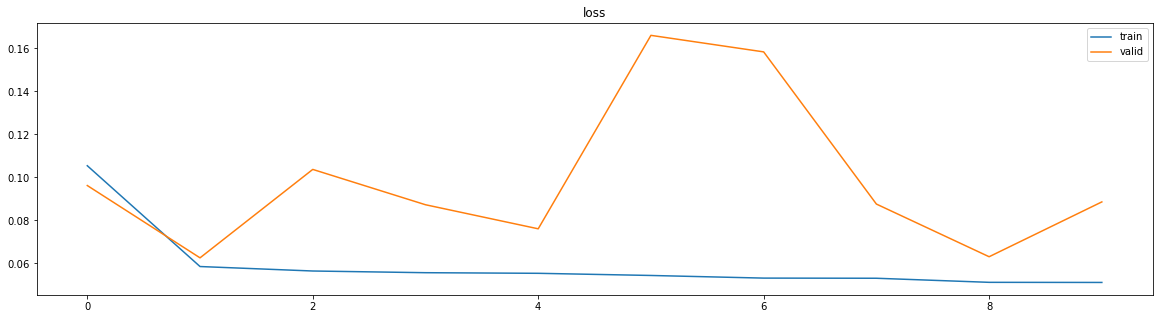

In [17]:
net = train(net,train_iter,valid_iter,loss_function,optimizer,num_epochs=10)

# make prediction

In [18]:
from sklearn.metrics import r2_score,mean_squared_error
from math import sqrt

def mape(a, b): 
    mask = a != 0
    return (np.fabs(a - b)/a)[mask].mean()*100

In [19]:
def make_prediction(state,action,output,streamn):
    
    y_pred = net(state,action)[0].detach().cpu().numpy()
    y_pred = data['mm_output'].inverse_transform(y_pred).ravel()
    
    y_pred2 = net(state,action)[1].detach().cpu().numpy()
    y_pred2 = data['mm_stream'].inverse_transform(y_pred2)
    
    y_real = output.detach().cpu().numpy()
    y_real = data['mm_output'].inverse_transform(y_real).ravel()
    
    y_real2 = stream.detach().cpu().numpy()
    y_real2 = data['mm_stream'].inverse_transform(y_real2)
    
    feed = action.detach().cpu().numpy()
    temp = [data['mm_action'].inverse_transform(feed[i]) for i in range(len(feed))]
    feed = np.array(temp)[:,:,0][:,0]
    
    table = pd.DataFrame()
    table['0619'] = feed
    table['0997_real'] = y_real
    table['0997_pred'] = y_pred
    table['真實單耗'] = feed/y_real
    table['預測單耗'] = feed/y_pred
    table['真實蒸氣'] = y_real2
    table['預測蒸氣'] = y_pred2
    
    return table

In [20]:
def make_metric(table):
    
    metric = pd.DataFrame(index=[0],columns=['R2(出料)','RMSE(單耗)','MAPE(單耗)'])
    metric['R2(出料)'] = r2_score(table['0997_real'],table['0997_pred'])
    metric['RMSE(單耗)'] = sqrt(mean_squared_error(table['真實單耗'],table['預測單耗']))
    metric['MAPE(單耗)'] = mape(table['真實單耗'],table['預測單耗'])
    metric.index.name = '出料'
    
    metric2 = pd.DataFrame(index=[0],columns=['R2','RMSE','MAPE'])
    metric2['R2'] = r2_score(table['真實蒸氣'],table['預測蒸氣'])
    metric2['RMSE'] = sqrt(mean_squared_error(table['真實蒸氣'],table['預測蒸氣']))
    metric2['MAPE'] = mape(table['真實蒸氣'],table['預測蒸氣'])
    metric2.index.name = '蒸氣'
    
    return metric,metric2

# train metric

In [21]:
state ,action, output, stream = train_iter.dataset.tensors
table = make_prediction(state,action,output,stream)
metric,metric2 = make_metric(table)
metric

,R2(出料),RMSE(單耗),MAPE(單耗)
出料,,,
0,0.93613,0.014422,1.062028


In [22]:
metric2

,R2,RMSE,MAPE
蒸氣,,,
0,-32.64153,20267.459634,43.571842


# test metric

In [23]:
state ,action, output, stream = test.tensors
table = make_prediction(state,action,output,stream)
metric,metric2 = make_metric(table)
metric

,R2(出料),RMSE(單耗),MAPE(單耗)
出料,,,
0,0.607065,0.025035,1.846094


In [24]:
metric2

,R2,RMSE,MAPE
蒸氣,,,
0,-462.02451,10799.448134,30.951601


# save 

In [25]:
joblib.dump(net,'../model/Critic.pkl')
print('save done!')

save done!
